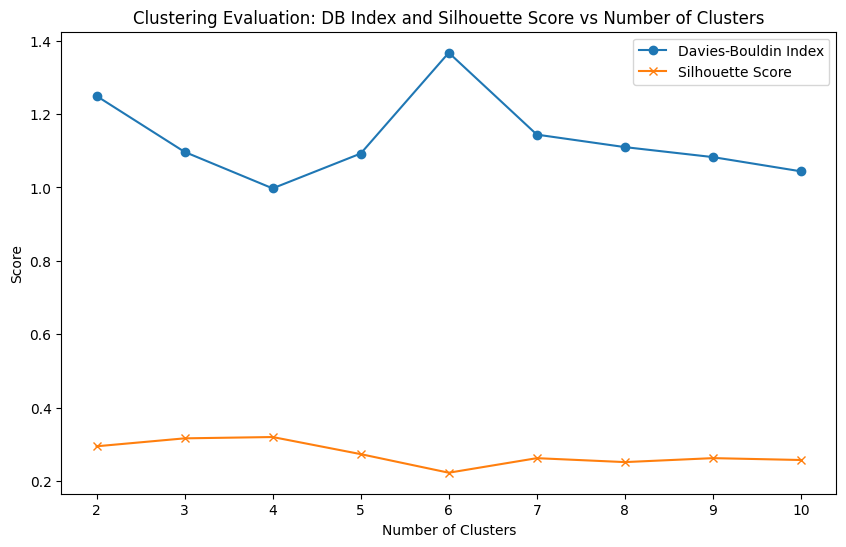

Optimal number of clusters: 4
DB Index: 0.9975879026509441
Silhouette Score: 0.32029123091701694

Cluster Centers (mean values for each cluster):
   TotalSpending  Frequency  AvgTransactionValue   Recency
0       1.159981   1.153062             0.251799 -0.349450
1       0.177620  -0.510926             1.221203  0.125380
2      -1.277299  -1.465073            -0.396918  2.514288
3      -0.611555  -0.231428            -0.694595 -0.305004

Cluster Sizes (Number of customers per cluster):
Cluster
3    85
0    56
1    42
2    16
Name: count, dtype: int64


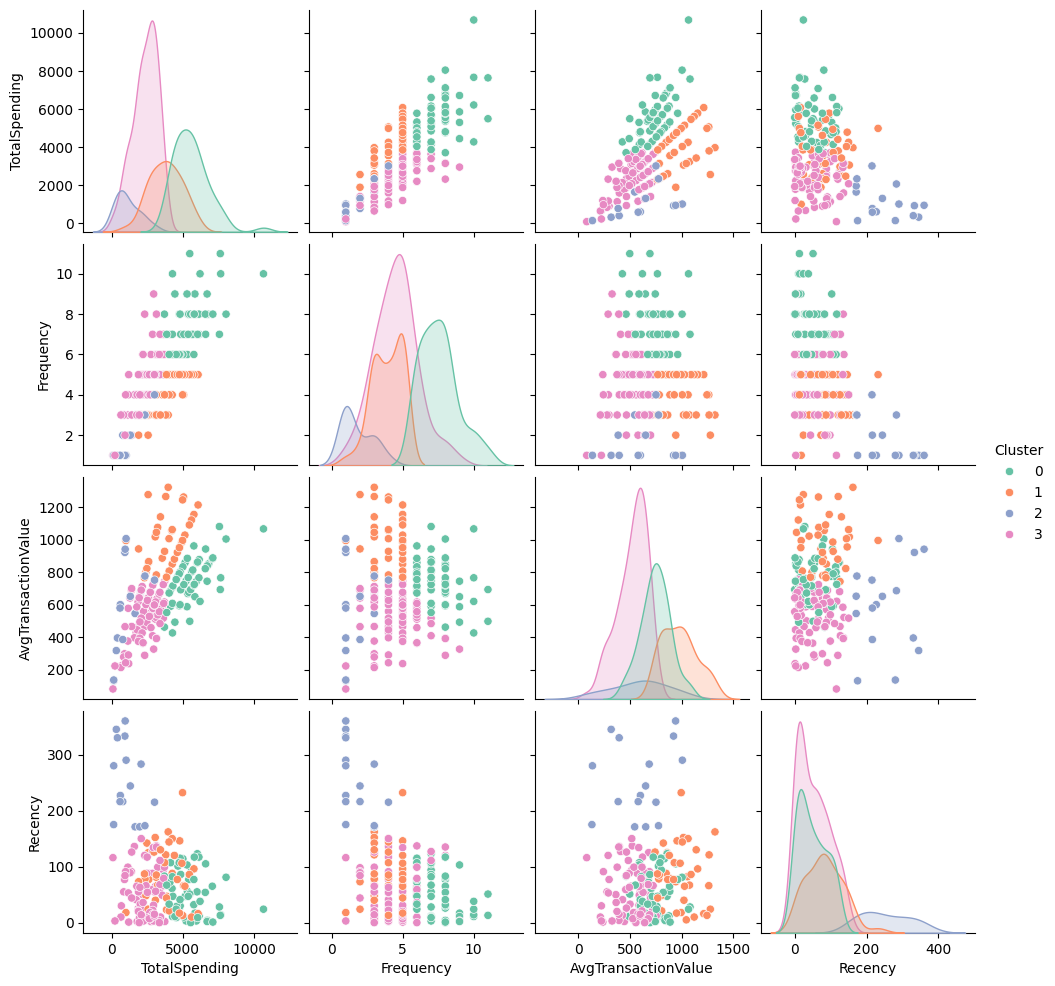

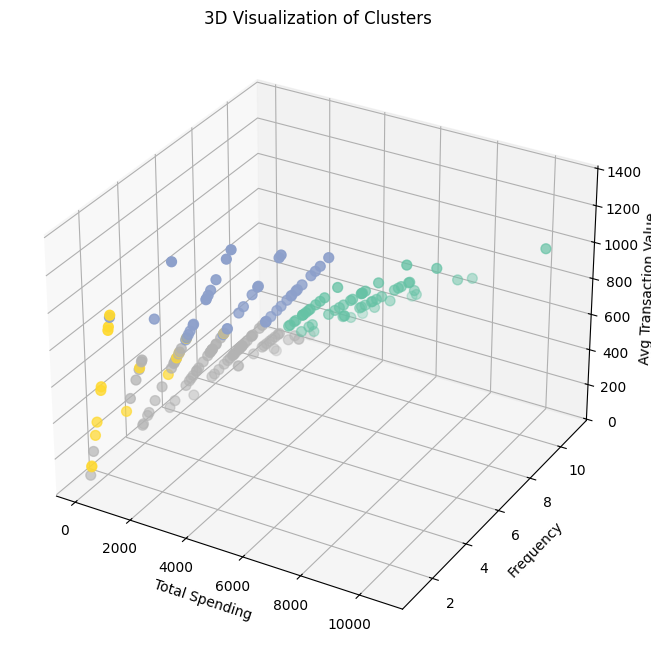

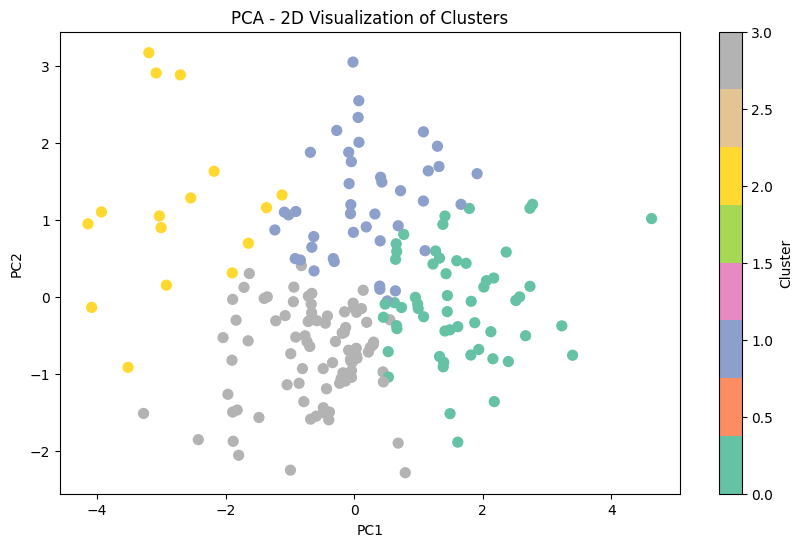

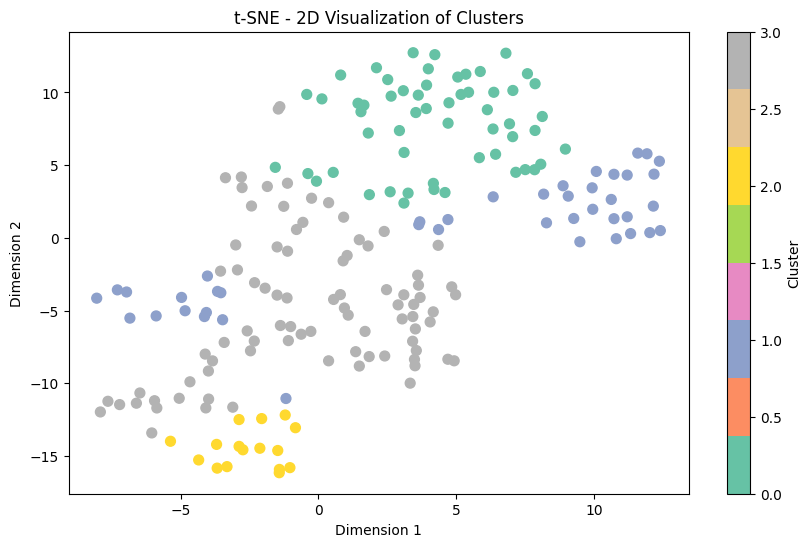

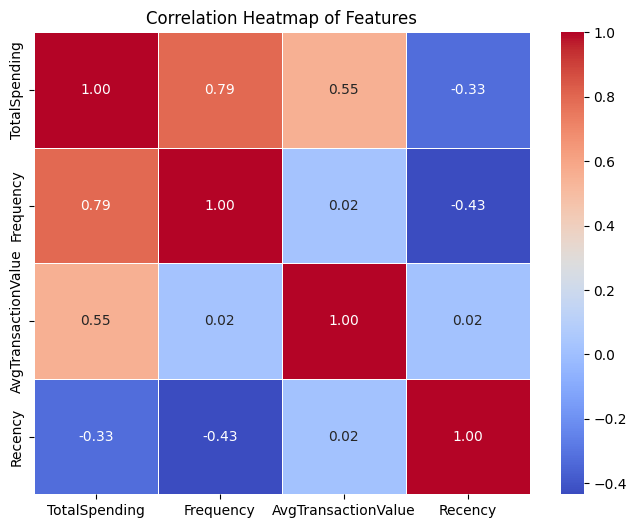


Cluster Profiling - Average Characteristics per Cluster:
         TotalSpending  Frequency  AvgTransactionValue     Recency
Cluster                                                           
0          5587.837857   7.553571           747.341628   49.160714
1          3792.015714   3.904762           977.418147   82.761905
2          1132.325000   1.812500           593.376510  251.812500
3          2349.350353   4.517647           522.726338   52.305882


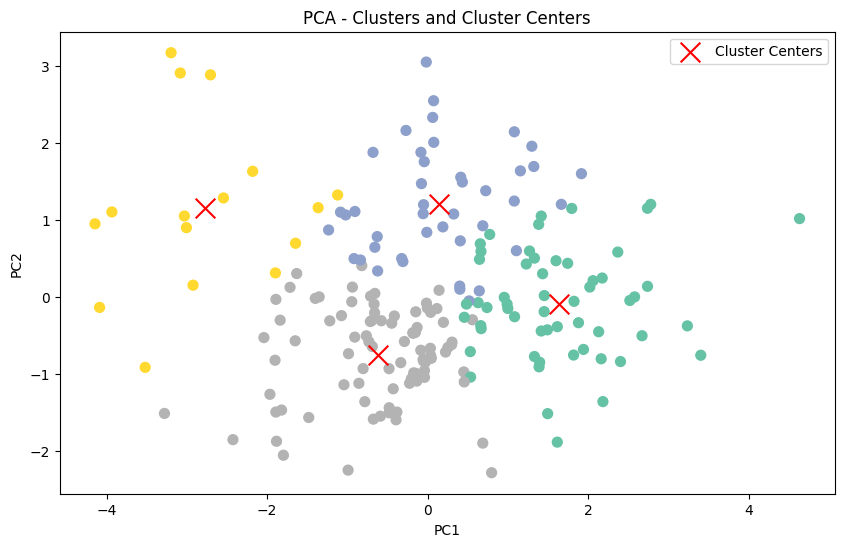

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5908\2291835200.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=customer_data['Cluster'], y=silhouette_vals, palette='Set2')


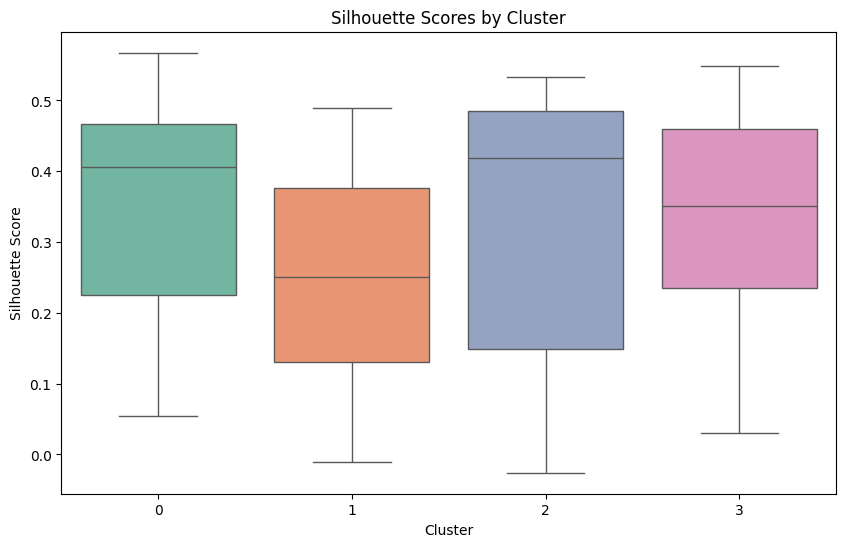

Cluster Consistency across bootstrap samples: 29.15%
Optimal Number of Clusters: 4
Davies-Bouldin Index: 0.9976
Calinski-Harabasz Index: 101.4487


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_samples, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

folder_path = r"C:/Users/lenovo/Desktop/EDA_folder"
customers = pd.read_csv(f"{folder_path}/Customers.csv")
products = pd.read_csv(f"{folder_path}/Products.csv")
transactions = pd.read_csv(f"{folder_path}/Transactions.csv")
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'count', 'mean'],
    'TransactionDate': 'max'
}).reset_index()

transaction_summary.columns = ['CustomerID', 'TotalSpending', 'Frequency', 'AvgTransactionValue', 'LastPurchaseDate']


current_date = transactions['TransactionDate'].max()
transaction_summary['Recency'] = (current_date - transaction_summary['LastPurchaseDate']).dt.days

# Merging with customer data
customer_data = pd.merge(customers, transaction_summary, on='CustomerID')

#Feature selection
features = customer_data[['TotalSpending', 'Frequency', 'AvgTransactionValue', 'Recency']]


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


db_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    
    # DB Index
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)
    
    # Silhouette Score
    silhouette_avg = silhouette_samples(scaled_features, labels).mean()
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, db_scores, marker='o', label='Davies-Bouldin Index')
plt.plot(k_values, silhouette_scores, marker='x', label='Silhouette Score')
plt.title('Clustering Evaluation: DB Index and Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

# Final clustering with optimal k 
optimal_k = k_values[db_scores.index(min(db_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)
print(f"Optimal number of clusters: {optimal_k}")
print(f"DB Index: {min(db_scores)}")
print(f"Silhouette Score: {max(silhouette_scores)}")

# Calculating cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
print("\nCluster Centers (mean values for each cluster):")
print(cluster_centers)
cluster_sizes = customer_data['Cluster'].value_counts()
print("\nCluster Sizes (Number of customers per cluster):")
print(cluster_sizes)

# Visualize Clusters
sns.pairplot(customer_data, vars=['TotalSpending', 'Frequency', 'AvgTransactionValue', 'Recency'], hue='Cluster', palette='Set2')
plt.show()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(customer_data['TotalSpending'], customer_data['Frequency'], customer_data['AvgTransactionValue'], c=customer_data['Cluster'], cmap='Set2', s=50)
ax.set_xlabel('Total Spending')
ax.set_ylabel('Frequency')
ax.set_zlabel('Avg Transaction Value')
plt.title('3D Visualization of Clusters')
plt.show()

# Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='Set2', s=50)
plt.title('PCA - 2D Visualization of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=customer_data['Cluster'], cmap='Set2', s=50)
plt.title('t-SNE - 2D Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Feature Correlation Heatmap
corr_matrix = customer_data[['TotalSpending', 'Frequency', 'AvgTransactionValue', 'Recency']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# Average Characteristics per Cluster
cluster_profiles = customer_data.groupby('Cluster')[['TotalSpending', 'Frequency', 'AvgTransactionValue', 'Recency']].mean()
print("\nCluster Profiling - Average Characteristics per Cluster:")
print(cluster_profiles)


pca_cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='Set2', s=50)
plt.scatter(pca_cluster_centers[:, 0], pca_cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('PCA - Clusters and Cluster Centers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Silhouette Scores by Cluster
silhouette_vals = silhouette_samples(scaled_features, customer_data['Cluster'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=customer_data['Cluster'], y=silhouette_vals, palette='Set2')
plt.title('Silhouette Scores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Score')
plt.show()

# Bootstrap Sampling
n_bootstrap = 100  # Number of bootstrap samples
cluster_consistency = []

for i in range(n_bootstrap):
    bootstrap_sample = resample(scaled_features, random_state=i)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    bootstrap_labels = kmeans.fit_predict(bootstrap_sample)
    cluster_consistency.append(bootstrap_labels)

consistent_clusters = (cluster_consistency[0] == cluster_consistency[1]).mean()
print(f"Cluster Consistency across bootstrap samples: {consistent_clusters*100:.2f}%")

# Clustering Metrics - DB Index and Calinski-Harabasz Index
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, customer_data['Cluster'])

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")





In [1]:
!pip install nbconvert
!pip install pyppeteer


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for websockets: filename=websockets-10.4-cp312-cp312-win_amd64.whl size=100738 sha256=fece15c9fbd5e34fb7298cd5bc9283f8d27a77eaadee122ccd73ad5f66e47635
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\80\cf\6d\5d7e4c920cb41925a178b2d2621889c520d648bab487b1d7fd
Successfully built websockets
  Attempting uninstall: websockets
    Found existing installation: websockets 13.1
    Uninstalling websockets-13.1:
      Successfully uninstalled websockets-13.1
  Attempting uninstall

In [2]:
!jupyter nbconvert --to pdf Sanya_Arora_Clustering.ipynb


Could not find platform independent libraries <prefix>
[NbConvertApp] Converting notebook Sanya_Arora_Clustering.ipynb to pdf
[NbConvertApp] Support files will be in Sanya_Arora_Clustering_files\
[NbConvertApp] Making directory .\Sanya_Arora_Clustering_files
[NbConvertApp] Writing 55918 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\Scripts\jupyter-nbconvert.EXE\__main__.py", line 7, in <module>
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\jupyter_core\application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\